# Stage 1 : converting a 3D model to a 2D images covering all angels 

In [1]:
import open3d
import wget
import cv2
import copy
import numpy as np
import matplotlib.pyplot as plt
import os
import uuid
import albumentations as A
import time
import skimage as ski
import glob 

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
mesh_file = "D:\\Ace\\meshdata\\Mixed Key.ply"
#Allen Key.obj"
print('visualizing the mesh using open3D')
mesh = open3d.io.read_triangle_mesh(mesh_file)
mesh.compute_vertex_normals()

visualizing the mesh using open3D


TriangleMesh with 10837 points and 17462 triangles.

In [3]:
coori=[0, 90, 180]

In [4]:
images = []
#saving Screanshots 
vis = open3d.visualization.Visualizer()
vis.create_window()


#take images from different angles 
for z in coori:
    for y in coori:
        for x in coori:
            
            #1.#Rotation
            mesh_r = copy.deepcopy(mesh)
            R = mesh.get_rotation_matrix_from_xyz((x, y, z))
            mesh_r.rotate(R, center=(0, 0, 0))
            
            vis.add_geometry(mesh_r)

            # get the image
            image = vis.capture_screen_float_buffer(True)

            # scale and convert to uint8 type
            Formated_Image = (255.0 * np.asarray(image)).astype(np.uint8)
            #img = cv2.resize(Formated_Image, (300, 400))
            images.append(Formated_Image)
            
            vis.remove_geometry(mesh_r)

            
vis.run()
vis.destroy_window()

# Stage 2 : Generating the masks for the 2D images then the synth. data 

In [5]:
len(images)

27

In [6]:
#Display Some Images
def Display_Some_Images(images):
    
    fig=plt.figure(figsize=(8, 8))
    # Define row and cols in the figure
    rows, cols = 2, 2
    
    # Display first four images
    for j in range(0, cols*rows):
        fig.add_subplot(rows, cols, j+1)
        plt.imshow(images[j])
        
    plt.show()

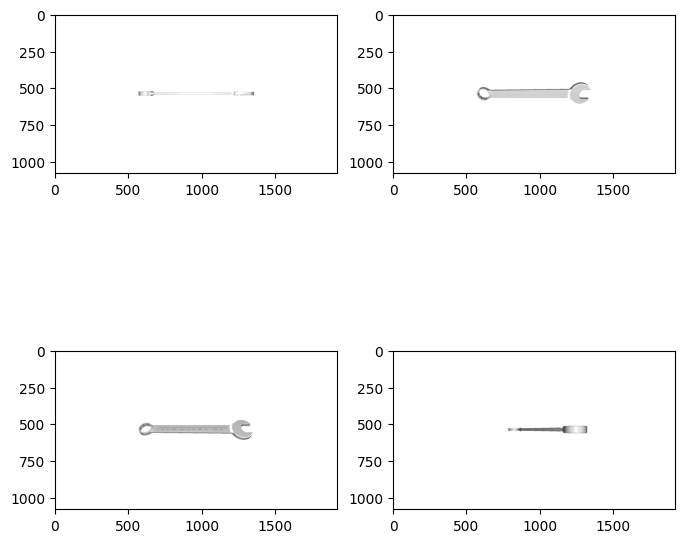

In [7]:
Display_Some_Images(images)

In [8]:
#Create Boolean masks 
Masks = []
# convert the image to grayscale
for img in images:
    gray_shapes = ski.color.rgb2gray(img)

    # blur the image to denoise
    blurred_shapes = ski.filters.gaussian(gray_shapes, sigma=1.0)
    #get the BIN mask (black BG, White Obj)
    t = 1
    binary_mask = blurred_shapes < t
    Masks.append(binary_mask)

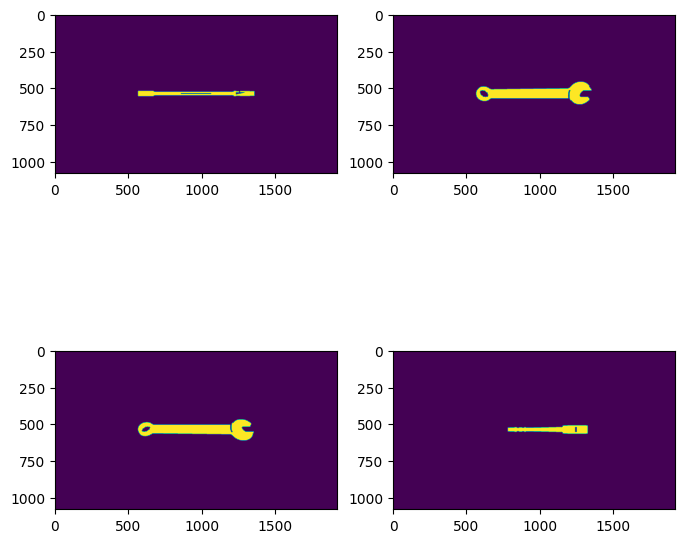

In [9]:
Display_Some_Images(Masks)

In [10]:
#Loading background images

file = "D:\\Ace\\meshdata\\Background\\*.*"
glob.glob(file)
# Using List Comprehension to read all images
BG = [cv2.imread(image) for image in glob.glob(file)]

In [11]:
len(BG)

60

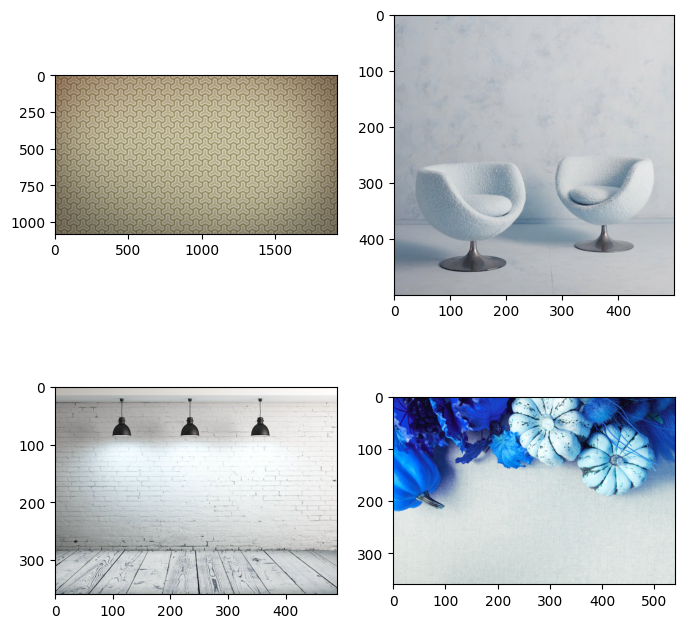

In [12]:
Display_Some_Images(BG)

# STG3 : Data Preprocessing 

Resizing background images

In [13]:
def resize_img(img, desired_max, desired_min=None):
   
    h, w = img.shape[0], img.shape[1]
    
    longest, shortest = max(h, w), min(h, w)
    longest_new = desired_max
    if desired_min:
        shortest_new = desired_min
    else:
        shortest_new = int(shortest * (longest_new / longest))
    
    if h > w:
        h_new, w_new = longest_new, shortest_new
    else:
        h_new, w_new = shortest_new, longest_new
        
    transform_resize = A.Compose([
        A.Sequential([
        A.Resize(h_new, w_new, interpolation=1, always_apply=False, p=1)
        ], p=1)
    ], is_check_shapes=False)
    
    img = img.astype(np.uint8)
    
    transformed = transform_resize(image=img)
    img_r = transformed["image"]
    
    return img_r

In [14]:
TransformedBG = []
for img in BG:
    
    img_bg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_bg_resized = resize_img(img_bg, desired_max=1920, desired_min=1080)
    
    #img = cv2.resize(img, (1920, 1080))
    TransformedBG.append(img_bg_resized)

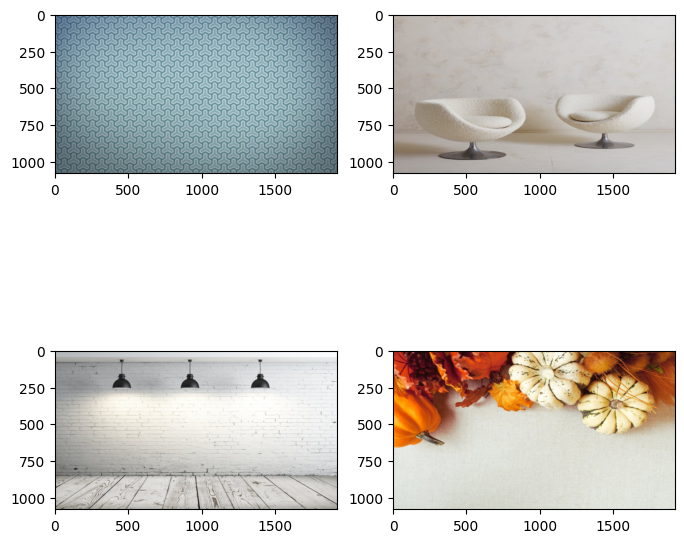

In [15]:
Display_Some_Images(TransformedBG)

Transforming object

In [16]:
def resize_transform_obj(img, mask, longest_min, longest_max, transforms=False):
   
    h, w = mask.shape[0], mask.shape[1]
    
    longest, shortest = max(h, w), min(h, w)
    longest_new = np.random.randint(longest_min, longest_max)
    shortest_new = int(shortest * (longest_new / longest))
    
    if h > w:
        h_new, w_new = longest_new, shortest_new
    else:
        h_new, w_new = shortest_new, longest_new
        
    transform_resize = A.Resize(h_new, w_new, interpolation=1, always_apply=False, p=1)

    transformed_resized = transform_resize(image=img, mask=mask)
    img_t = transformed_resized["image"]
    mask_t = transformed_resized["mask"]
        
    if transforms:
        transformed = transforms(image=img_t, mask=mask_t)
        img_t = transformed["image"]
        mask_t = transformed["mask"]
        
    return img_t, mask_t


#initiating fillters


#rotates image, adds blur, changes colors, contrast & brightness in a wide range.
#This aggressive transform will be used to transform background noise objects.
transforms_bg_obj = A.Compose([
    A.RandomRotate90(p=1),
    A.ColorJitter(brightness=0.3,
                  contrast=0.3,
                  saturation=0.3,
                  hue=0.07,
                  always_apply=False,
                  p=1),
    A.Blur(blur_limit=(3,15),
           always_apply=False,
           p=0.5)
])

#rotates image and changes contrast & brightness in a narrow range.
#This negligible will be used to transform objects of interest.
transforms_obj = A.Compose([
    A.RandomRotate90(p=1),
    A.RandomBrightnessContrast(brightness_limit=(-0.1, 0.2),
                               contrast_limit=0.1,
                               brightness_by_max=True,
                               always_apply=False,
                               p=1)
])

In [17]:
img_trans = []
mask_trans = []

for i in range(27): 
    img, mask = images[i], Masks[i]
    img = img.astype(np.uint8)
    mask = mask.astype(np.uint8)
    img_t, mask_t = resize_transform_obj(img, mask, 300, 400, transforms=transforms_obj)
    img_trans.append(img_t)
    mask_trans.append(mask_t)
    

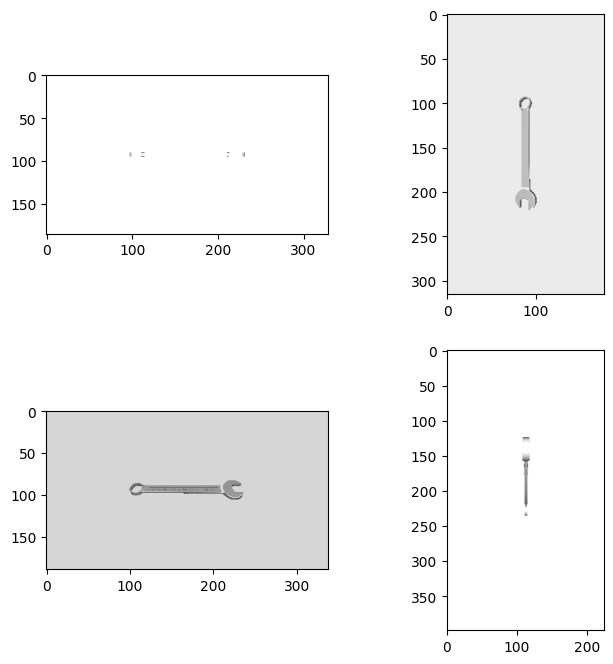

In [18]:
Display_Some_Images(img_trans)

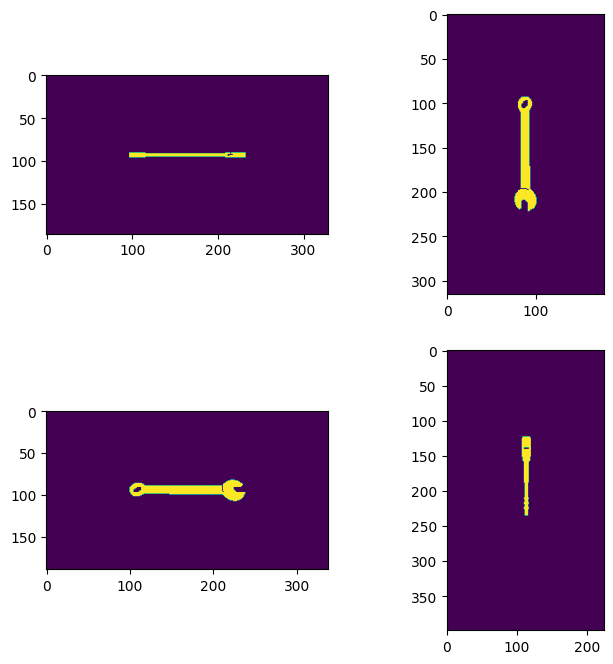

In [19]:
Display_Some_Images(mask_trans)

In [20]:
print(mask_trans[0].shape)
print(img_trans[0].shape)

(185, 329)
(185, 329, 3)


Adding object to background

In [21]:
def add_obj(img_comp, mask_comp, img, mask, x, y, idx):
    
    '''
    img_comp : composition of objects
    mask_comp : composition of objects masks
    img : image of object
    mask : binary mask of object
    x, y : coordinates where center of img is placed
    idx : number of object add
    Function returns: img_comp in CV2 RGB format ,  mask_comp
    '''
    #h_part : part of the image which gets into the frame of img_comp along y-axis
    #w_part : part of the image which gets into the frame of img_comp along x-axis
    
    h_comp, w_comp = img_comp.shape[0], img_comp.shape[1]
    
    h, w = img.shape[0], img.shape[1]
    
    x = x - int(w/2)
    y = y - int(h/2)
    
    mask_b = mask == 1
    mask_rgb_b = np.stack([mask_b, mask_b, mask_b], axis=2)
    
    if x >= 0 and y >= 0:
        
        h_part = h - max(0, y+h-h_comp)
        w_part = w - max(0, x+w-w_comp) 

        img_comp[y:y+h_part, x:x+w_part, :] = img_comp[y:y+h_part, x:x+w_part, :] * ~mask_rgb_b[0:h_part, 0:w_part, :] + (img * mask_rgb_b)[0:h_part, 0:w_part, :]
        mask_comp[y:y+h_part, x:x+w_part] = mask_comp[y:y+h_part, x:x+w_part] * ~mask_b[0:h_part, 0:w_part] + (idx * mask_b)[0:h_part, 0:w_part]
        mask_added = mask[0:h_part, 0:w_part]
        
    elif x < 0 and y < 0:
        
        h_part = h + y
        w_part = w + x
        
        img_comp[0:0+h_part, 0:0+w_part, :] = img_comp[0:0+h_part, 0:0+w_part, :] * ~mask_rgb_b[h-h_part:h, w-w_part:w, :] + (img * mask_rgb_b)[h-h_part:h, w-w_part:w, :]
        mask_comp[0:0+h_part, 0:0+w_part] = mask_comp[0:0+h_part, 0:0+w_part] * ~mask_b[h-h_part:h, w-w_part:w] + (idx * mask_b)[h-h_part:h, w-w_part:w]
        mask_added = mask[h-h_part:h, w-w_part:w]
        
    elif x < 0 and y >= 0:
        
        h_part = h - max(0, y+h-h_comp)
        w_part = w + x
        
        img_comp[y:y+h_part, 0:0+w_part, :] = img_comp[y:y+h_part, 0:0+w_part, :] * ~mask_rgb_b[0:h_part, w-w_part:w, :] + (img * mask_rgb_b)[0:h_part, w-w_part:w, :]
        mask_comp[y:y+h_part, 0:0+w_part] = mask_comp[y:y+h_part, 0:0+w_part] * ~mask_b[0:h_part, w-w_part:w] + (idx * mask_b)[0:h_part, w-w_part:w]
        mask_added = mask[0:h_part, w-w_part:w]
        
    elif x >= 0 and y < 0:
        
        h_part = h + y
        w_part = w - max(0, x+w-w_comp)
        
        img_comp[0:0+h_part, x:x+w_part, :] = img_comp[0:0+h_part, x:x+w_part, :] * ~mask_rgb_b[h-h_part:h, 0:w_part, :] + (img * mask_rgb_b)[h-h_part:h, 0:w_part, :]
        mask_comp[0:0+h_part, x:x+w_part] = mask_comp[0:0+h_part, x:x+w_part] * ~mask_b[h-h_part:h, 0:w_part] + (idx * mask_b)[h-h_part:h, 0:w_part]
        mask_added = mask[h-h_part:h, 0:w_part]
    
    return img_comp, mask_comp, mask_added


Text(0.5, 1.0, 'Composition mask')

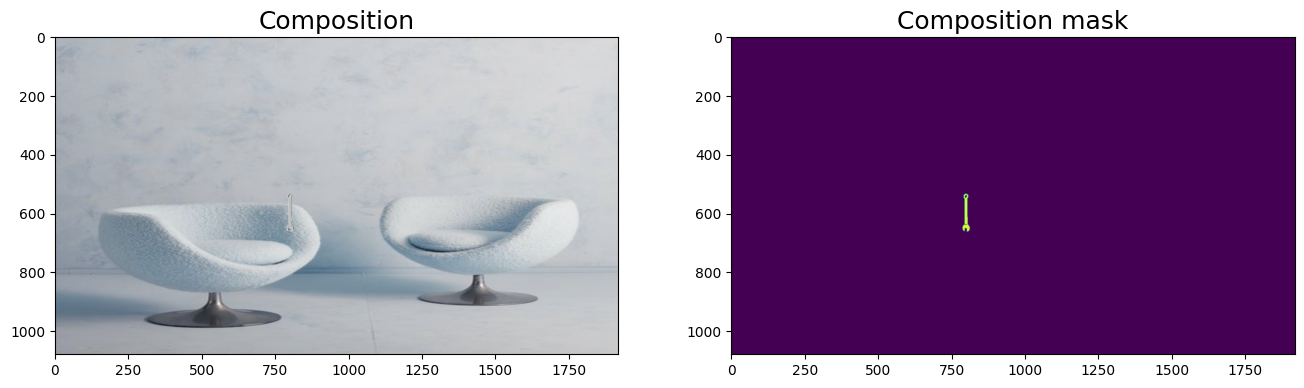

In [22]:
img_bg = TransformedBG[1]
img_bg = cv2.cvtColor(img_bg, cv2.COLOR_BGR2RGB)

h, w = img_bg.shape[0], img_bg.shape[1]

#mask of the initial composition
mask_comp = np.zeros((h,w), dtype=np.uint8)

img, mask = img_trans[1], mask_trans[1]

img_comp, mask_comp, _ = add_obj(img_bg, mask_comp, img, mask, x=800, y=600, idx=1)

fig, ax = plt.subplots(1, 2, figsize=(16, 7))
ax[0].imshow(img_comp)
ax[0].set_title('Composition', fontsize=18)
ax[1].imshow(mask_comp)
ax[1].set_title('Composition mask', fontsize=18)

it's hard to see but my object is there in the pic :D

i will not be adding additional noise to the frames as my backgrounds are very busy

# Creating synthetic composition

the algorithm allows me to create as much data as i like 

In [23]:
def check_areas(mask_comp, obj_areas, overlap_degree=0.3):
    obj_ids = np.unique(mask_comp).astype(np.uint8)[1:-1]
    masks = mask_comp == obj_ids[:, None, None]
    
    ok = True
    
    if len(np.unique(mask_comp)) != np.max(mask_comp) + 1:
        ok = False
        return ok
    
    for idx, mask in enumerate(masks):
        if np.count_nonzero(mask) / obj_areas[idx] < 1 - overlap_degree:
            ok = False
            break
            
    return ok   

In [51]:
def create_composition(img_comp_bg,
                       max_objs=5,
                       overlap_degree=0.2,
                       max_attempts_per_obj=10):
    
    '''
    img_comp_bg : background img
    
    max_objs : maximum number of objects to be added
    
    overlap_degree : threshold which defines if 
    
        a randomly added object of interest overlaps any 
        of the earlier added objects of interest more than 
        threshold defined by (overlap_degree) func
        
    max_attempts_per_obj : number of attempts the function
        will try to add object without overlapping other 
        objects by more than threshold 
        defined by overlap_degree
    
    '''

    img_comp = img_comp_bg.copy()
    h, w = img_comp.shape[0], img_comp.shape[1]
    mask_comp = np.zeros((h,w), dtype=np.uint8)
    
    obj_areas = []
    labels_comp = []
    num_objs = np.random.randint(max_objs) + 2
    
    i = 1
    
    for _ in range(1, num_objs):

        obj_idx = np.random.randint(1) + 1
        
        for _ in range(max_attempts_per_obj):

            imgs_number = 27 #len(obj_dict[obj_idx]['images'])
            idx = np.random.randint(imgs_number)
            #img_path = obj_dict[obj_idx]['images'][idx]
            #mask_path = obj_dict[obj_idx]['masks'][idx]
            #img, mask = get_img_and_mask(img_path, mask_path)
            img, mask = images[idx].astype(np.uint8), Masks[idx].astype(np.uint8)

            x, y = np.random.randint(w), np.random.randint(h)
            #longest_min = obj_dict[obj_idx]['longest_min']
            #longest_max = obj_dict[obj_idx]['longest_max']
            longest_min , longest_max = 800 , 1000
            img, mask = resize_transform_obj(img,
                                             mask,
                                             longest_min,
                                             longest_max,
                                             transforms=transforms_obj)

            if i == 1:
                img_comp, mask_comp, mask_added = add_obj(img_comp,
                                                          mask_comp,
                                                          img,
                                                          mask,
                                                          x,
                                                          y,
                                                          i)
                
                obj_areas.append(np.count_nonzero(mask_added))
                labels_comp.append(obj_idx)
                i += 1
                break
                
            else:        
                img_comp_prev, mask_comp_prev = img_comp.copy(), mask_comp.copy()
                img_comp, mask_comp, mask_added = add_obj(img_comp,
                                                          mask_comp,
                                                          img,
                                                          mask,
                                                          x,
                                                          y,
                                                          i)
                
                ok = check_areas(mask_comp, obj_areas, overlap_degree)
                if ok:
                    obj_areas.append(np.count_nonzero(mask_added))
                    labels_comp.append(obj_idx)
                    i += 1
                    break
                else:
                    img_comp, mask_comp = img_comp_prev.copy(), mask_comp_prev.copy()        
        
    return img_comp, mask_comp, labels_comp, obj_areas

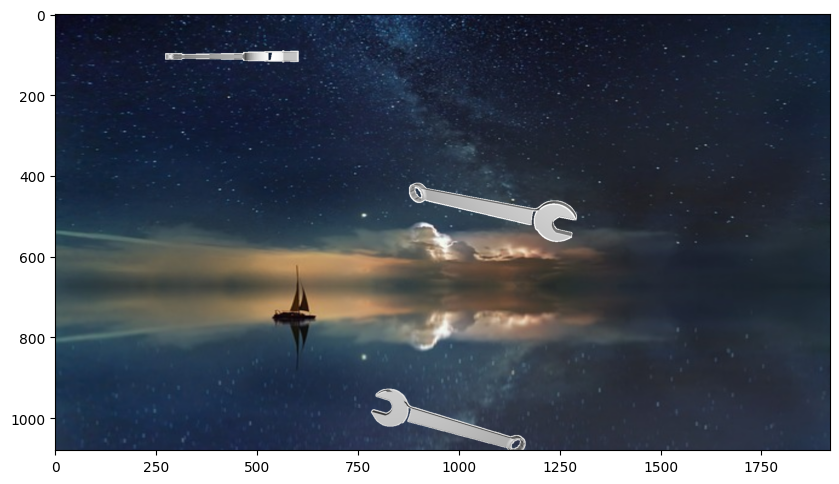

In [77]:
img_comp, mask_comp, labels_comp, obj_areas = create_composition(TransformedBG[np.random.randint(0,59)],
                                                                 max_objs=5,
                                                                 overlap_degree=0.2,
                                                                 max_attempts_per_obj=10)
plt.figure(figsize=(10,10))
plt.imshow(img_comp)

In [71]:
print("Labels (classes of the objects) on the composition in order of object's addition:", labels_comp)
obj_ids = np.unique(mask_comp).astype(np.uint8)[1:]
masks = mask_comp == obj_ids[:, None, None]

print("Degree of how much area of each object is overlapped:")

for idx, mask in enumerate(masks):
    print(np.count_nonzero(mask) / obj_areas[idx])

Labels (classes of the objects) on the composition in order of object's addition: [1, 1]
Degree of how much area of each object is overlapped:
1.0
1.0


# bounding boxes for each added object

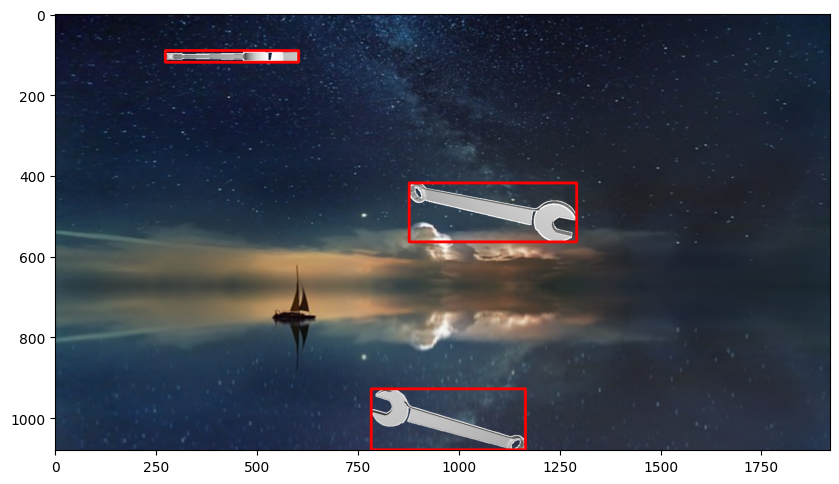

In [80]:
colors = {1: (255,0,0), 2: (0,255,0), 3: (0,0,255)}

img_comp_bboxes = img_comp.copy()

obj_ids = np.unique(mask_comp).astype(np.uint8)[1:]
masks = mask_comp == obj_ids[:, None, None]

for i in range(len(obj_ids)):
    pos = np.where(masks[i])
    xmin = np.min(pos[1])
    xmax = np.max(pos[1])
    ymin = np.min(pos[0])
    ymax = np.max(pos[0])
    img_comp_bboxes = cv2.rectangle(img_comp_bboxes,
                                    (xmin, ymin),
                                    (xmax,ymax),
                                    colors[labels_comp[i]],
                                    6)
      
plt.figure(figsize=(10,10))
plt.imshow(img_comp_bboxes)  

# Annotations in YOLO format

In [55]:
def create_yolo_annotations(mask_comp, labels_comp):
    comp_w, comp_h = mask_comp.shape[1], mask_comp.shape[0]
    
    obj_ids = np.unique(mask_comp).astype(np.uint8)[1:]
    masks = mask_comp == obj_ids[:, None, None]

    annotations_yolo = []
    for i in range(len(labels_comp)):
        pos = np.where(masks[i])
        xmin = np.min(pos[1])
        xmax = np.max(pos[1])
        ymin = np.min(pos[0])
        ymax = np.max(pos[0])

        xc = (xmin + xmax) / 2
        yc = (ymin + ymax) / 2
        w = xmax - xmin
        h = ymax - ymin

        annotations_yolo.append([labels_comp[i] - 1,
                                 round(xc/comp_w, 5),
                                 round(yc/comp_h, 5),
                                 round(w/comp_w, 5),
                                 round(h/comp_h, 5)])
        
    return annotations_yolo

In [56]:
annotations_yolo = create_yolo_annotations(mask_comp, labels_comp)
for i in range(len(annotations_yolo)):
    print(' '.join(str(el) for el in annotations_yolo[i]))

0 0.56016 0.3213 0.18073 0.05741
0 0.90938 0.89537 0.17708 0.01296
0 0.28438 0.50602 0.08542 0.33981


# Generate the Dataset

In [57]:
IMAGES_PATH = os.path.join('D:\\Ace','dataset')

path = os.path.join(IMAGES_PATH, 'train')
if not os.path.exists(path):
    !mkdir {path} 
    
path = os.path.join(IMAGES_PATH, 'valid')
if not os.path.exists(path):
    !mkdir {path}               

In [58]:
def generate_dataset(imgs_number, folder, split='train'):
    time_start = time.time()
    for j in tqdm(range(imgs_number)):
        img_comp_bg = TransformedBG[np.random.randint(0,59)]
        
        img_comp, mask_comp, labels_comp, _ = create_composition(img_comp_bg,
                                                                 max_objs=5,
                                                                 overlap_degree=0.2,
                                                                 max_attempts_per_obj=10)

        img_comp = cv2.cvtColor(img_comp, cv2.COLOR_RGB2BGR)
        cv2.imwrite(os.path.join(folder, split,'images','{}.jpg').format(j), img_comp)

        annotations_yolo = create_yolo_annotations(mask_comp, labels_comp)
        for i in range(len(annotations_yolo)):
            with open(os.path.join(folder, split,'labels','{}.txt').format(j), "a") as f:
                f.write(' '.join(str(el) for el in annotations_yolo[i]) + '\n')
                
    time_end = time.time()
    time_total = round(time_end - time_start)
    time_per_img = round((time_end - time_start) / imgs_number, 1)
    
    print("Generation of {} synthetic images is completed. It took {} seconds, or {} seconds per image".format(imgs_number, time_total, time_per_img))
    print("Images are stored in '{}'".format(os.path.join(folder, split, 'images')))
    print("Annotations are stored in '{}'".format(os.path.join(folder, split, 'labels')))

In [59]:
from tqdm import tqdm

folder = 'D:\\Ace\\dataset'
generate_dataset(300, folder=folder, split='train')
generate_dataset(100, folder=folder, split='valid')

100%|██████████| 300/300 [02:16<00:00,  2.20it/s]


Generation of 300 synthetic images is completed. It took 136 seconds, or 0.5 seconds per image
Images are stored in 'D:\Ace\dataset\train\images'
Annotations are stored in 'D:\Ace\dataset\train\labels'


100%|██████████| 100/100 [00:42<00:00,  2.37it/s]

Generation of 100 synthetic images is completed. It took 42 seconds, or 0.4 seconds per image
Images are stored in 'D:\Ace\dataset\valid\images'
Annotations are stored in 'D:\Ace\dataset\valid\labels'


# STG4 : Yolo Training  

Creating our data.yaml file 

In [64]:
f = os.path.join('D:\\Ace\\dataset', "data"+".yaml")         

f = open(f, "a")

f.write("train: D:\\Ace\\dataset\\train\\images")
f.write("\n")
f.write("val: D:\\Ace\\dataset\\valid\\images")
f.write("\n")
f.write("\n")
f.write("nc: 1\nnames: ['Mixed Key']")
f.close()

In [61]:
from tqdm import tqdm
import ultralytics
from ultralytics import YOLO
ultralytics.checks()

Ultralytics YOLOv8.0.231 🚀 Python-3.10.13 torch-2.1.2+cpu CPU (13th Gen Intel Core(TM) i7-1360P)
Setup complete ✅ (16 CPUs, 15.7 GB RAM, 135.3/200.0 GB disk)


In [65]:
%cd D:\\Ace\\dataset

D:\Ace\dataset


In [66]:
%cd D:\\Ace\\dataset
    
# Load a model
model = YOLO('yolov8n.yaml')  # build a new model from YAML

# Train the model
results = tqdm(model.train(data='data.yaml', epochs=20, imgsz=1280 ))

D:\Ace\dataset

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv  

train: Scanning D:\Ace\dataset\train\labels... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<00:00, 380.63it/s]


train: New cache created: D:\Ace\dataset\train\labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning D:\Ace\dataset\valid\labels... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<00:00, 271.02it/s]

val: New cache created: D:\Ace\dataset\valid\labels.cache


Plotting labels to runs\detect\train5\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20         0G      3.356      4.786      4.289         70       1280: 100%|██████████| 19/19 [18:01<00:00, 56.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [01:06<00:00, 16.64s/it]

                   all        100        282    0.00253       0.27    0.00182   0.000533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20         0G      3.334      4.295      4.085         80       1280: 100%|██████████| 19/19 [15:44<00:00, 49.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:47<00:00, 11.87s/it]

                   all        100        282    0.00167      0.177    0.00133    0.00044



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20         0G      2.972      3.904      3.782         74       1280: 100%|██████████| 19/19 [11:15<00:00, 35.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:45<00:00, 11.43s/it]

                   all        100        282    0.00193      0.206    0.00171   0.000514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20         0G       2.82      3.557      3.466         64       1280: 100%|██████████| 19/19 [11:44<00:00, 37.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:48<00:00, 12.07s/it]

                   all        100        282    0.00167      0.177    0.00359    0.00111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20         0G      2.654       3.25      3.222         76       1280: 100%|██████████| 19/19 [11:39<00:00, 36.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:45<00:00, 11.28s/it]

                   all        100        282    0.00167      0.138    0.00113   0.000367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20         0G      2.582      3.127      3.072         82       1280: 100%|██████████| 19/19 [11:49<00:00, 37.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:45<00:00, 11.36s/it]

                   all        100        282    0.00153      0.163    0.00116   0.000336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20         0G      2.431      2.885      2.898         89       1280: 100%|██████████| 19/19 [11:22<00:00, 35.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:45<00:00, 11.48s/it]

                   all        100        282      0.141      0.143     0.0549     0.0162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20         0G      2.353      2.738      2.779         74       1280: 100%|██████████| 19/19 [10:45<00:00, 33.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:46<00:00, 11.60s/it]

                   all        100        282        0.2      0.365      0.212      0.084



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20         0G        2.3      2.581      2.743         84       1280: 100%|██████████| 19/19 [10:57<00:00, 34.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:46<00:00, 11.69s/it]

                   all        100        282      0.326      0.416      0.316      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20         0G      2.234      2.409      2.672         86       1280: 100%|██████████| 19/19 [11:20<00:00, 35.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:46<00:00, 11.59s/it]

                   all        100        282      0.345      0.454      0.351      0.176


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20         0G      2.097      2.701      2.549         45       1280: 100%|██████████| 19/19 [10:27<00:00, 33.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:46<00:00, 11.53s/it]

                   all        100        282      0.436      0.383      0.399      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20         0G      2.062      2.515      2.539         32       1280: 100%|██████████| 19/19 [11:38<00:00, 36.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:45<00:00, 11.37s/it]

                   all        100        282       0.56      0.323      0.388      0.183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20         0G      1.986      2.356      2.445         44       1280: 100%|██████████| 19/19 [09:57<00:00, 31.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:43<00:00, 10.99s/it]

                   all        100        282      0.493      0.465      0.433      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20         0G      1.911      2.278      2.408         32       1280: 100%|██████████| 19/19 [10:08<00:00, 32.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:42<00:00, 10.52s/it]

                   all        100        282      0.525      0.536      0.535      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20         0G      1.864       2.17      2.344         36       1280: 100%|██████████| 19/19 [10:04<00:00, 31.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:43<00:00, 10.94s/it]

                   all        100        282      0.572      0.564      0.549      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20         0G      1.864      2.085      2.365         33       1280: 100%|██████████| 19/19 [10:23<00:00, 32.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:42<00:00, 10.69s/it]

                   all        100        282      0.694      0.585      0.668      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20         0G      1.824      2.028      2.313         26       1280: 100%|██████████| 19/19 [10:04<00:00, 31.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:44<00:00, 11.21s/it]

                   all        100        282      0.709      0.578      0.651      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20         0G      1.786      1.979      2.311         34       1280: 100%|██████████| 19/19 [10:07<00:00, 32.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:45<00:00, 11.35s/it]

                   all        100        282      0.668      0.585      0.658      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20         0G      1.735      1.961       2.24         28       1280: 100%|██████████| 19/19 [10:27<00:00, 33.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:44<00:00, 11.18s/it]

                   all        100        282      0.801       0.67      0.785      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20         0G      1.696      1.891      2.216         35       1280: 100%|██████████| 19/19 [11:22<00:00, 35.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:44<00:00, 11.05s/it]

                   all        100        282      0.766      0.661      0.761      0.502



20 epochs completed in 4.084 hours.
Optimizer stripped from runs\detect\train5\weights\last.pt, 6.3MB
Optimizer stripped from runs\detect\train5\weights\best.pt, 6.3MB

Validating runs\detect\train5\weights\best.pt...
Ultralytics YOLOv8.0.231 🚀 Python-3.10.13 torch-2.1.2+cpu CPU (13th Gen Intel Core(TM) i7-1360P)
YOLOv8n summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:37<00:00,  9.42s/it]


                   all        100        282      0.808       0.67      0.786      0.503
Speed: 6.7ms preprocess, 313.4ms inference, 0.0ms loss, 5.8ms postprocess per image
Results saved to runs\detect\train5


0it [00:00, ?it/s]

In [69]:
!yolo task=detect mode=predict model=runs/detect/train5/weights/best.pt source=D:\\Ace\\test

Ultralytics YOLOv8.0.231 ðŸš€ Python-3.10.13 torch-2.1.2+cpu CPU (13th Gen Intel Core(TM) i7-1360P)
YOLOv8n summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs

image 1/7 D:\Ace\test\1.jpeg: 1280x960 (no detections), 152.0ms
image 2/7 D:\Ace\test\2.jpeg: 1280x960 (no detections), 135.5ms
image 3/7 D:\Ace\test\3.jpeg: 1280x960 (no detections), 191.0ms
image 4/7 D:\Ace\test\5.jpeg: 1280x960 (no detections), 156.7ms
image 5/7 D:\Ace\test\6.jpeg: 1280x960 (no detections), 182.9ms
image 6/7 D:\Ace\test\7.jpeg: 1280x960 (no detections), 169.0ms
image 7/7 D:\Ace\test\8.jpeg: 1280x960 2 Mixed Keys, 159.0ms
Speed: 5.1ms preprocess, 163.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 960)
Results saved to runs\detect\predict2
ðŸ’¡ Learn more at https://docs.ultralytics.com/modes/predict
